In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import glob
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

# Define data root directory
Axis = "Obasi_Time2Vec_X_"
data_dir = "/home/jintaek/Desktop/Nas/John_VR_Study/New_OutputData_x"
model_save_path = "/home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model"
model_filename = Axis + "final_model.pth"
model_path = os.path.join(model_save_path, model_filename)

losses_filename = Axis+"losses.npz"
losses_path = os.path.join(model_save_path, losses_filename)

device = torch.device("cuda")
print("Device:", device)

Device: cuda


In [2]:
all_scalers = {'scalers': {}, 'label_scalers': {}}

label_scalers = {}
train_x = []
test_x = []
test_y = []

for file in tqdm(os.listdir(data_dir), desc="Processing Files", unit="file"):

    # Store csv file in a Pandas DataFrame
    df = pd.read_csv('{}/{}'.format(data_dir, file))
    df.columns = ['time', 'pos', 'acc', 'ref']
    df = df[['ref','time', 'pos', 'acc']]

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc

    # Define lookback period and split inputs/labels
    lookback = 40
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)

    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)

    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.2*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    # test_x[file] = (inputs[-test_portion:])
    # test_y[file] = (labels[-test_portion:])
    test_x.append(inputs[-test_portion:])
    test_y.append(labels[-test_portion:])

    # Save the scalers in the dictionary
    file_name_without_extension = os.path.splitext(file)[0]
    all_scalers['scalers'][file_name_without_extension] = sc
    all_scalers['label_scalers'][file_name_without_extension] = label_sc

Processing Files:   0%|          | 0/1350 [00:00<?, ?file/s]

In [3]:
# Save all the scalers in two separate files using joblib
scaler_dir = '/home/jintaek/Desktop/Nas/John_VR_Study/scalers'  # You can change this directory
os.makedirs(scaler_dir, exist_ok=True)

joblib.dump(all_scalers['scalers'], os.path.join(scaler_dir, Axis +'input_scalers.joblib'))
joblib.dump(all_scalers['label_scalers'], os.path.join(scaler_dir, Axis +'label_scalers.joblib'))

test_x = np.concatenate(test_x)
test_y = np.concatenate(test_y)
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [4]:
def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        #print(w.shape, t1.shape, b.shape)
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], -1)

In [5]:
class SineActivation(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.1):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, tau):
        # return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)
        return self.dropout(t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0))

In [6]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2, dropout=0.3):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = SineActivation(d_model, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [7]:
model = TransformerModel().to(device)

print("Shape of training input data:", train_x.shape)
print("Shape of training label data:", train_y.shape)
print("Shape of testing input data:", test_x.shape)
print("Shape of testing label data:", test_y.shape)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

# Create the directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Check if a saved model exists
if os.path.exists(model_path):
    # Load the model state dictionary
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from: {model_path}")

    # Check if saved losses exist
    if os.path.exists(losses_path):
        # Load training and validation losses
        with np.load(losses_path) as data:
            all_train_losses = list(data['all_train_losses'])
            all_val_losses = list(data['all_val_losses'])
        print(f"Losses loaded from: {losses_path}")
    else:
        print("No saved losses found. Starting with empty losses.")
        all_train_losses = []
        all_val_losses = []
else:
    print("No pre-trained model found. Training from scratch.")
    all_train_losses = []
    all_val_losses = []

/home/jintaek/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Shape of training input data: (87919, 40, 4)
Shape of training label data: (87919, 1)
Shape of testing input data: (21321, 40, 4)
Shape of testing label data: (21321, 1)
No pre-trained model found. Training from scratch.


/home/jintaek/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    all_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.8f}")

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).float()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    all_val_losses.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    current_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.8f}")
    print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        model_filename = f"T2Vmodel_epoch_{epoch + 1}.pth"
        model_path = os.path.join(model_save_path, Axis+model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch + 1} to: {model_path}")

Epoch 1/100, Training Loss: 0.07630793
Epoch 1/100, Validation Loss: 0.02688183
Total Time Elapsed: 6.089721441268921 seconds
Epoch 2/100, Training Loss: 0.02228759
Epoch 2/100, Validation Loss: 0.01591594
Total Time Elapsed: 5.795933485031128 seconds
Epoch 3/100, Training Loss: 0.01507286
Epoch 3/100, Validation Loss: 0.01275457
Total Time Elapsed: 5.827665328979492 seconds
Epoch 4/100, Training Loss: 0.01198149
Epoch 4/100, Validation Loss: 0.01179637
Total Time Elapsed: 5.851527452468872 seconds
Epoch 5/100, Training Loss: 0.01028017
Epoch 5/100, Validation Loss: 0.01088436
Total Time Elapsed: 5.873556137084961 seconds
Epoch 6/100, Training Loss: 0.00925339
Epoch 6/100, Validation Loss: 0.01052816
Total Time Elapsed: 5.88102388381958 seconds
Epoch 7/100, Training Loss: 0.00849751
Epoch 7/100, Validation Loss: 0.01045966
Total Time Elapsed: 5.987416505813599 seconds
Epoch 8/100, Training Loss: 0.00791222
Epoch 8/100, Validation Loss: 0.01010305
Total Time Elapsed: 5.7365570068359375 

In [9]:
# Save the final model at the end of training
model_filename = Axis + "T2Vfinal_model.pth"
model_path = os.path.join(model_save_path, model_filename)
torch.save(model.state_dict(), model_path)
print(f"Final model saved to: {model_path}")

# Save losses
np.savez(losses_path, all_train_losses=all_train_losses, all_val_losses=all_val_losses)
print(f"Losses saved to: {losses_path}")

Final model saved to: /home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/Obasi_Time2Vec_X_T2Vfinal_model.pth
Losses saved to: /home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/Obasi_Time2Vec_X_losses.npz


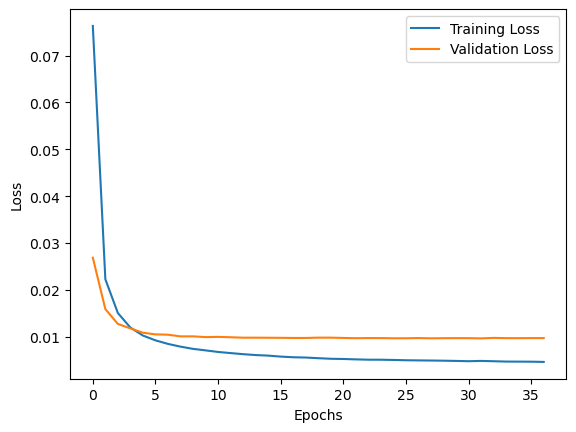

In [10]:
# Plot training and validation losses
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set font size and style for the entire figure
plt.rc('font', size=15, family='Times New Roman')

def remove_nan_rows(data):
    # Remove rows with NaN values
    nan_rows = np.isnan(data)
    return data[~nan_rows]

def limit_epochs(data, limit=10):
    # Limit the data to the first 'limit' epochs
    return data[:limit]

# Load data from the npz files for X, Y, and Z
data_X = np.load('/home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/Obasi_Time2Vec_X_losses.npz')
data_Y = np.load('/home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/Obasi_Time2Vec_X_losses.npz')
data_Z = np.load('/home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/Obasi_Time2Vec_X_losses.npz')

# Assuming you want to plot the first variable found in the keys
train_loss_X = data_X[list(data_X.keys())[0]]
test_loss_X = data_X[list(data_X.keys())[1]]

train_loss_Y = data_Y[list(data_Y.keys())[0]]
test_loss_Y = data_Y[list(data_Y.keys())[1]]

train_loss_Z = data_Z[list(data_Z.keys())[0]]
test_loss_Z = data_Z[list(data_Z.keys())[1]]

# Remove NaN values and limit epochs for X
train_loss_X = remove_nan_rows(train_loss_X)
test_loss_X = remove_nan_rows(test_loss_X)
train_loss_X = limit_epochs(train_loss_X)
test_loss_X = limit_epochs(test_loss_X)

# Remove NaN values and limit epochs for Y
train_loss_Y = remove_nan_rows(train_loss_Y)
test_loss_Y = remove_nan_rows(test_loss_Y)
train_loss_Y = limit_epochs(train_loss_Y)
test_loss_Y = limit_epochs(test_loss_Y)

# Remove NaN values and limit epochs for Z
train_loss_Z = remove_nan_rows(train_loss_Z)
test_loss_Z = remove_nan_rows(test_loss_Z)
train_loss_Z = limit_epochs(train_loss_Z)
test_loss_Z = limit_epochs(test_loss_Z)

# Perform t-test for X
t_stat_paired_X, p_value_paired_X = stats.ttest_rel(train_loss_X, test_loss_X, alternative='greater')
print(f"P-value for X: {p_value_paired_X}")

# Perform t-test for Y
t_stat_paired_Y, p_value_paired_Y = stats.ttest_rel(train_loss_Y, test_loss_Y, alternative='greater')
print(f"P-value for Y: {p_value_paired_Y}")

# Perform t-test for Z
t_stat_paired_Z, p_value_paired_Z = stats.ttest_rel(train_loss_Z, test_loss_Z, alternative='greater')
print(f"P-value for Z: {p_value_paired_Z}")

# Plot subplots for X, Y, and Z
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot for X
axs[0].plot(range(1, 11), train_loss_X, linestyle='-', linewidth=2, color='blue', label='Train')
axs[0].plot(range(1, 11), test_loss_X, linestyle='-', linewidth=2, color='red', label='Test')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')
axs[0].set_title("(a) Model loss: X-axis", loc='left')
axs[0].set_xlim(1, 10)  # Adjust the X-axis limits
axs[0].set_xticks(range(1, 11))  # Set x-axis ticks
axs[0].set_xticklabels(axs[0].get_xticks())  # Use default font style
axs[0].set_ylim(0.005, 0.07)  # Adjust the Y-axis limits
axs[0].set_yticks(np.linspace(0.0050, 0.0650, 3))  # Set y-axis ticks

# Plot for Y
axs[1].plot(range(1, 11), train_loss_Y, linestyle='-', linewidth=2, color='blue', label='Train')
axs[1].plot(range(1, 11), test_loss_Y, linestyle='-', linewidth=2, color='red', label='Test')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title("(b) Model loss: Y-axis", loc='left')
axs[1].set_xlim(1, 10)  # Adjust the X-axis limits
axs[1].set_xticks(range(1, 11))  # Set x-axis ticks
axs[1].set_xticklabels(axs[1].get_xticks())  # Use default font style
axs[1].set_ylim(0.005, 0.07)  # Adjust the Y-axis limits
axs[1].set_yticks(np.linspace(0.0050, 0.0650, 3))  # Set y-axis ticks

# Plot for Z
axs[2].plot(range(1, 11), train_loss_Z, linestyle='-', linewidth=2, color='blue', label='Train')
axs[2].plot(range(1, 11), test_loss_Z, linestyle='-', linewidth=2, color='red', label='Test')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend(loc='upper right')
axs[2].set_title("(c) Model loss: Z-axis", loc='left')
axs[2].set_xlim(1, 10)  # Adjust the X-axis limits
axs[2].set_xticks(range(1, 11))  # Set x-axis ticks
axs[2].set_xticklabels(axs[2].get_xticks())  # Use default font style
axs[2].set_ylim(0.005, 0.07)  # Adjust the Y-axis limits
axs[2].set_yticks(np.linspace(0.0050, 0.0650, 3))  # Set y-axis ticks

# Adjust layout to remove space around the subplots
plt.tight_layout()

# Save the plot
plt.savefig('Obasi_lossPlot.png', dpi=3000, bbox_inches='tight')
# plt.savefig('Obasi_lossPlot.pdf', format='pdf', dpi=3000, bbox_inches='tight')

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jintaek/Desktop/Nas/VR_control_Code/VR_control/model/X_losses.npz'